# Импорт библиотек

In [2]:
import pandas as pd                                     # для работы с таблицами (как Excel в коде)
import numpy as np                                      # для математических операций
import matplotlib.pyplot as plt                         # для графиков
import seaborn as sns                                   # для красивых графиков
from sklearn.model_selection import train_test_split    # для разделения данных
from sklearn.preprocessing import StandardScaler        # для нормализации данных
from sklearn.linear_model import LinearRegression       # простая модель
from sklearn.ensemble import GradientBoostingRegressor  # сложная модель
from sklearn.metrics import mean_squared_error, mean_absolute_error  # для оценки качества

# Загрузка данных

In [3]:
train_csv = pd.read_csv('../data/train.csv')
test_csv = pd.read_csv('../data/test.csv')

# Первичный анализ данных

In [4]:
print("\nИнформация о данных:")
print(train_csv.info())

print("\nОсновные статистики:")
print(train_csv.describe())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float

# Разделение на признаки и целевую переменную

In [5]:
# Разделяем на признаки (X) и целевую переменную (y)
# Признаки - это то, на основе чего мы предсказываем
# Целевая переменная - то, что мы предсказываем (стоимость)

x = train_csv.drop("cost", axis=1)          # все колонки КРОМЕ cost
x = x.drop("id", axis=1)                    # удаляем id (это просто идентификатор, не признак!)
y = train_csv["cost"]                       # только колонка cost

# Проверка пропущенных значений

In [6]:
print("\nПропущенные значения")
print(x.isnull().sum())                           # посчитает пропуски в каждой колонке


Пропущенные значения
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
dtype: int64


# Визуализация распределения целевой переменной

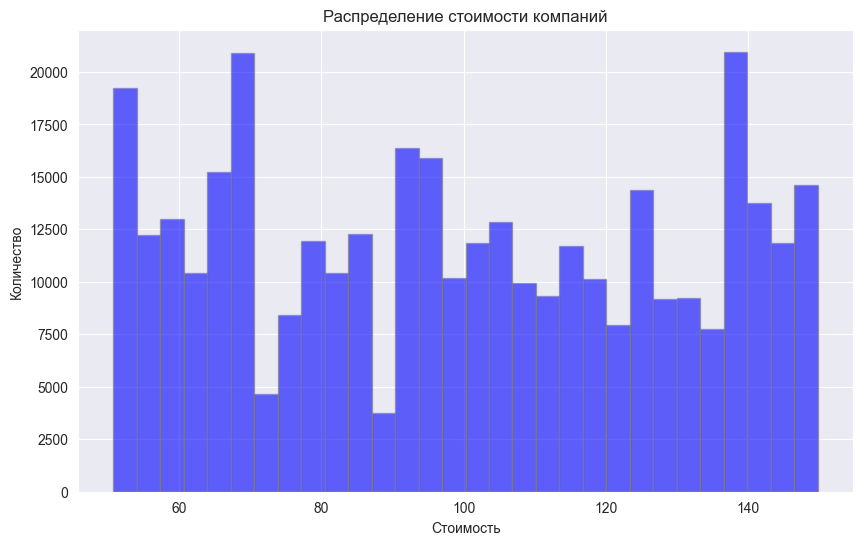

In [7]:
# 1. Смотрим на распределение стоимости
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, alpha=0.6, color="blue", edgecolor="gray", linewidth=1)
plt.title("Распределение стоимости компаний")
plt.xlabel("Стоимость")
plt.ylabel("Количество")
plt.show()

# Анализ корреляций

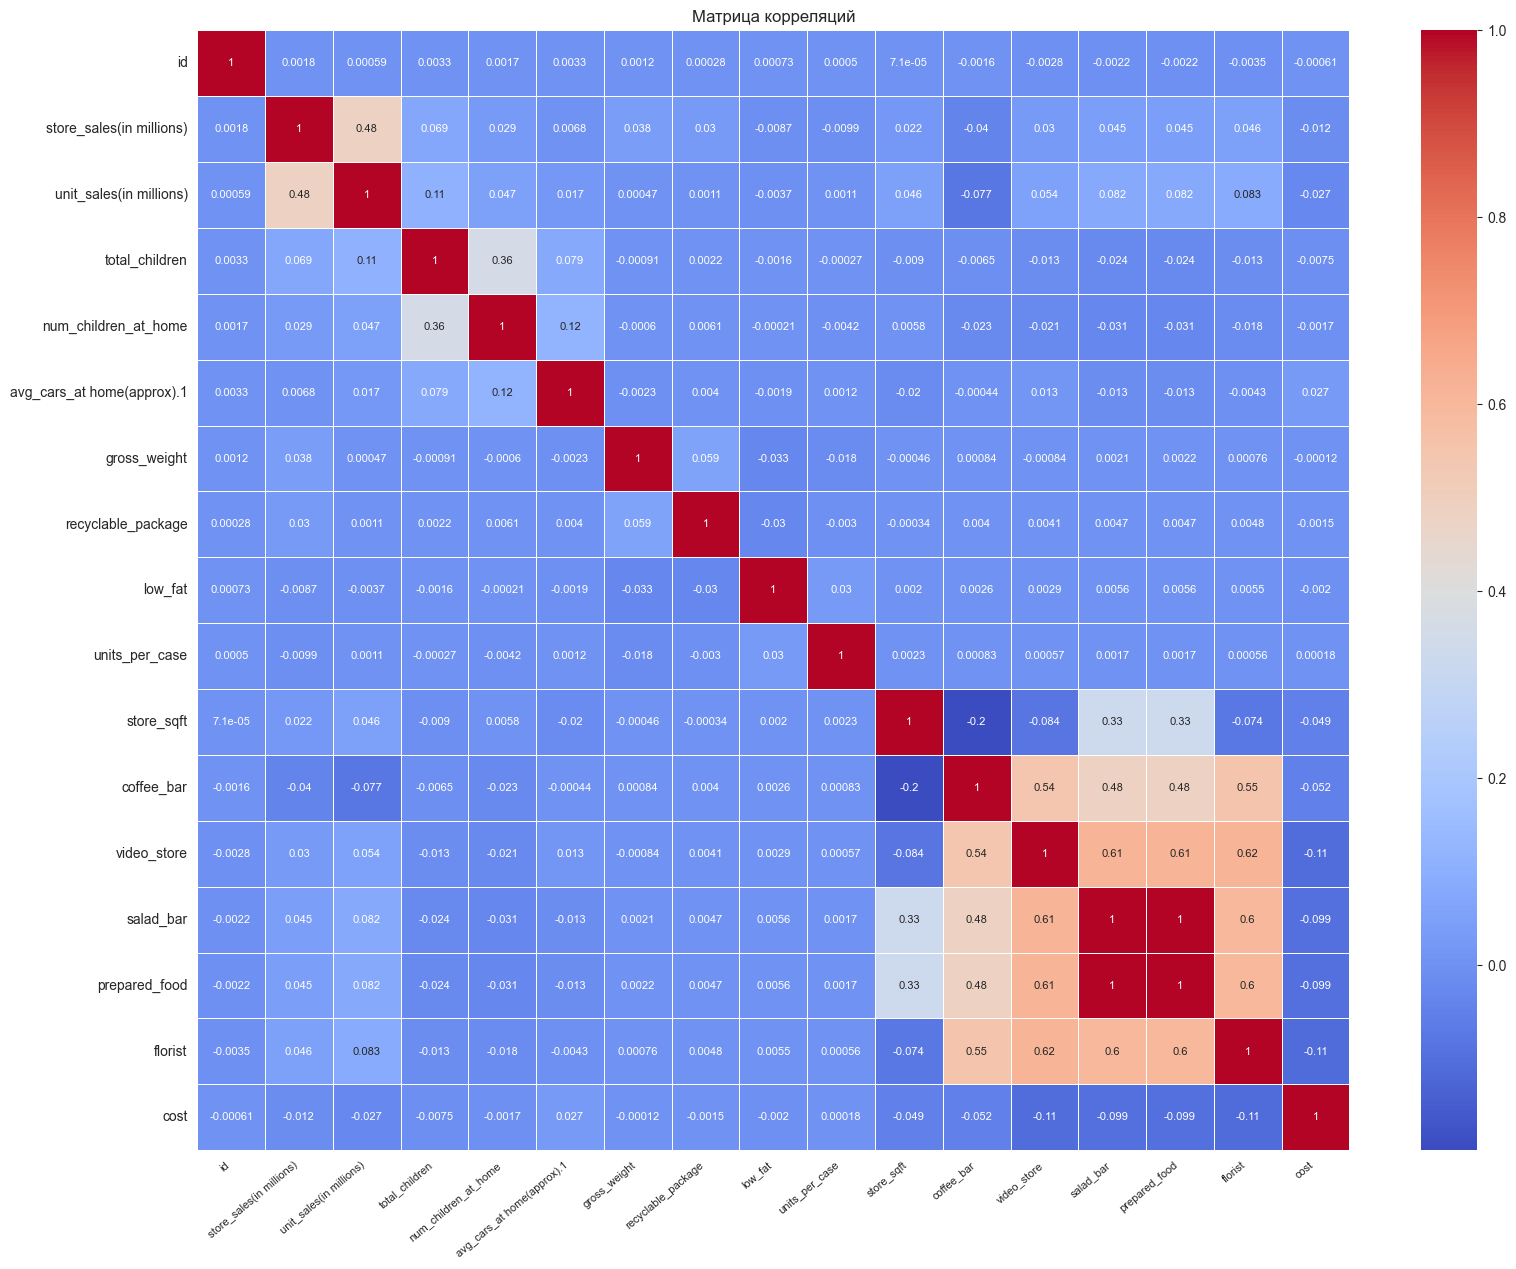

In [8]:
# 2. Смотрим корреляции (взаимосвязи между переменными)
plt.figure(figsize=(18, 14))
correlation_matrix = train_csv.corr()               # считаем корреляции
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, linecolor="white", annot_kws={"size": 8})
plt.title("Матрица корреляций")
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.xticks(rotation=40, ha='right', fontsize=8)
plt.show()

# Отбор значимых признаков

In [9]:
# 3. Смотрим на самые важные признаки для стоимости
correlation_with_cost = correlation_matrix["cost"].sort_values(ascending=False)
print("\nКорреляция признаков со стоимостью:")
print(correlation_with_cost)


Корреляция признаков со стоимостью:
cost                          1.000000
avg_cars_at home(approx).1    0.027098
units_per_case                0.000180
gross_weight                 -0.000116
id                           -0.000611
recyclable_package           -0.001455
num_children_at_home         -0.001727
low_fat                      -0.001975
total_children               -0.007482
store_sales(in millions)     -0.012387
unit_sales(in millions)      -0.026509
store_sqft                   -0.049201
coffee_bar                   -0.052086
salad_bar                    -0.098810
prepared_food                -0.098843
video_store                  -0.106786
florist                      -0.110414
Name: cost, dtype: float64


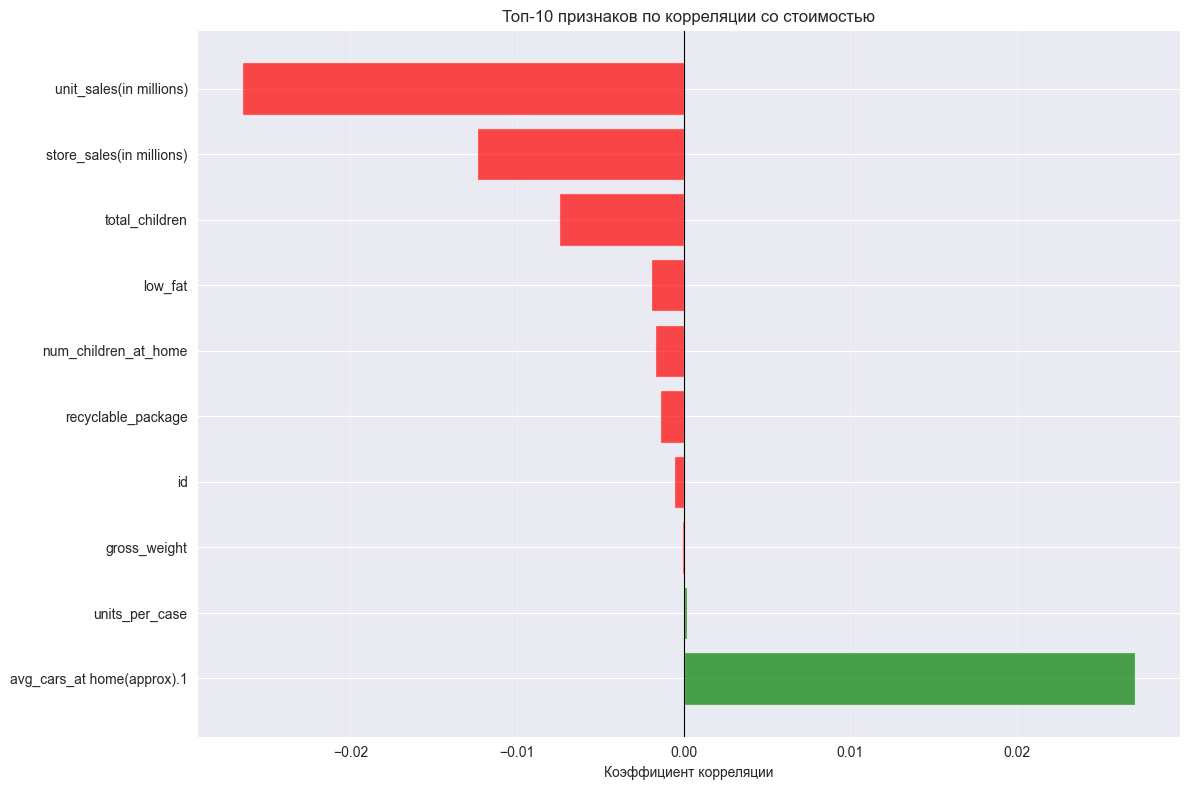

In [10]:
# визуализируем топ-10 признаков по корреляции со стоимостью
plt.figure(figsize=(12, 8))
top_correlations = correlation_with_cost.drop("cost").head(10)
colors = ['green' if x > 0 else 'red' for x in top_correlations.values]
plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel("Коэффициент корреляции")
plt.title("Топ-10 признаков по корреляции со стоимостью")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Далее делим данные для обучения и теста
# Возьмем 80% для обучения, 20% для тестирования
# random_state=42 для того чтобы результат можно было повторить
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

print(f"Размер тренировочного набора: {X_train.shape[0]} примеров")
print(f"Размер тестового набора: {X_test.shape[0]} примеров")
print(f"Количество признаков: {X_train.shape[1]}")

Размер тренировочного набора: 288268 примеров
Размер тестового набора: 72068 примеров
Количество признаков: 15


In [15]:
# Нормализуем данные: приводим все признаки к одной шкале (среднее=0, стандартное отклонение=1)
scaler = StandardScaler()

# Обучаем нормализатор на тренировочных данных
X_train_scaled = scaler.fit_transform(X_train)

# Применяем ту же нормализацию к тестовым данным
X_test_scaled = scaler.transform(X_test)

print("Тренировочные данные после нормализации:")
print(f"Среднее значение: {X_train_scaled.mean(axis=0)[:5].round(4)}")  # показываем первые 5 признаков
print(f"Стандартное отклонение: {X_train_scaled.std(axis=0)[:5].round(4)}")

Тренировочные данные после нормализации:
Среднее значение: [ 0. -0. -0. -0. -0.]
Стандартное отклонение: [1. 1. 1. 1. 1.]


# Обучаем модельку

In [16]:
# Создаем и обучаем модель линейной регрессии
baseline_model = LinearRegression()

# Обучаем на нормализованных тренировочных данных
baseline_model.fit(X_train_scaled, y_train)

# Проверяем на тренировочном и тестовом наборах
y_train_pred = baseline_model.predict(X_train_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

print(f"\nКоэффициенты модели (первые 5):")
for i in range(min(5, len(baseline_model.coef_))):
    print(f"  {X_train.columns[i]}: {baseline_model.coef_[i]:.4f}")
print(f"\nКонстанта модели: {baseline_model.intercept_:.4f}")


Коэффициенты модели (первые 5):
  store_sales(in millions): 0.0873
  unit_sales(in millions): -0.3213
  total_children: -0.3110
  num_children_at_home: -0.0899
  avg_cars_at home(approx).1: 0.8213

Константа модели: 99.6413


In [22]:
# Вычисление метрик качества
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Метрики качества модели:")
print(f"RMSE на тренировочных данных: {train_rmse:.4f}")
print(f"RMSE на тестовых данных: {test_rmse:.4f}")
print(f"MAE на тренировочных данных: {train_mae:.4f}")
print(f"MAE на тестовых данных: {test_mae:.4f}")

Метрики качества модели:
RMSE на тренировочных данных: 29.6431
RMSE на тестовых данных: 29.6570
MAE на тренировочных данных: 25.5734
MAE на тестовых данных: 25.6016


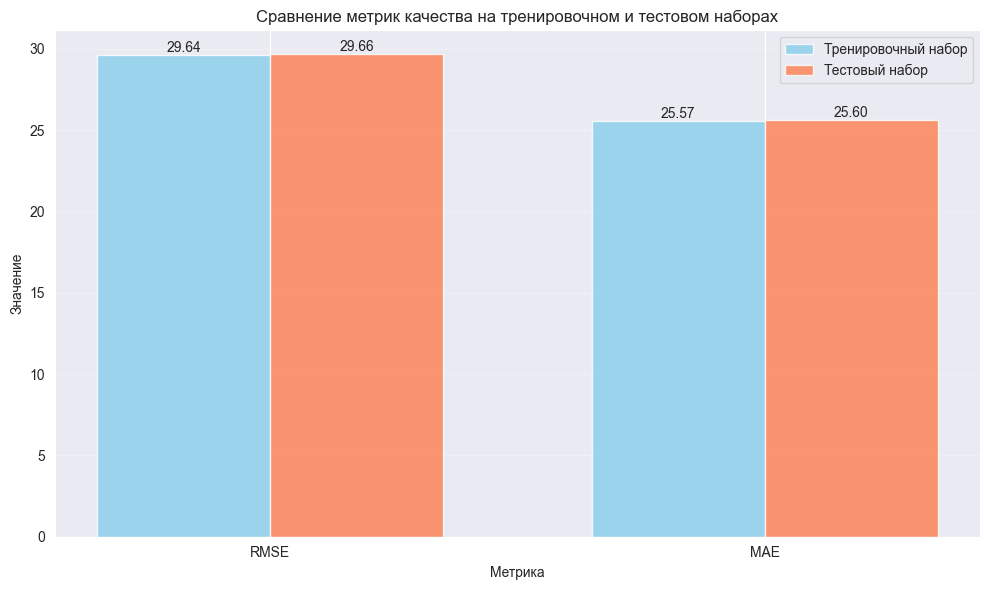

In [23]:
# График 2: Сравнение метрик на тренировочном и тестовом наборах
metrics_data = {
    'RMSE': [train_rmse, test_rmse],
    'MAE': [train_mae, test_mae]
}

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(metrics_data))
width = 0.35

bars1 = ax.bar(x_pos - width/2, [metrics_data[m][0] for m in metrics_data], width, 
               label='Тренировочный набор', alpha=0.8, color='skyblue')
bars2 = ax.bar(x_pos + width/2, [metrics_data[m][1] for m in metrics_data], width,
               label='Тестовый набор', alpha=0.8, color='coral')

ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик качества на тренировочном и тестовом наборах')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_data.keys())
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Значения над столбками
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [26]:
print("""
ИТОГ:

1. ОПИСАНИЕ ДАННЫХ:
   - Всего примеров в обучающем наборе: {}
   - Количество признаков: {}
   - Целевая переменная: cost (стоимость компании)
   - Пропущенные значения: НЕТ 

2. АНАЛИЗ ПРИЗНАКОВ:
   - Самые важные признаки :
   {}

3. КАЧЕСТВО МОДЕЛИ:
   - Тестовой RMSE: {:.4f} (средняя ошибка предсказания)
   - Тестовой MAE:  {:.4f} (средняя абсолютная ошибка)



""".format(
    X_train.shape[0],
    X_train.shape[1],
    '\n   '.join([f"- {idx}: {corr:.4f}" for idx, corr in correlation_with_cost.drop("cost").head(5).items()]),
    test_rmse,
    test_mae
))


ИТОГ:

1. ОПИСАНИЕ ДАННЫХ:
   - Всего примеров в обучающем наборе: 288268
   - Количество признаков: 15
   - Целевая переменная: cost (стоимость компании)
   - Пропущенные значения: НЕТ 

2. АНАЛИЗ ПРИЗНАКОВ:
   - Самые важные признаки :
   - avg_cars_at home(approx).1: 0.0271
   - units_per_case: 0.0002
   - gross_weight: -0.0001
   - id: -0.0006
   - recyclable_package: -0.0015

3. КАЧЕСТВО МОДЕЛИ:
   - Тестовой RMSE: 29.6570 (средняя ошибка предсказания)
   - Тестовой MAE:  25.6016 (средняя абсолютная ошибка)




